In [ ]:
# Necessary Imports
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# Define a simple CNN for MNIST classification
class MNIST_CNN(torch.nn.Module):
    """
    A simple Convolutional Neural Network for MNIST digit classification.
    This network consists of:
    - 2 convolutional layers (with ReLU + MaxPooling)
    - 1 fully connected layer that outputs 10 classes (digits 0 through 9).
    """
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3)
        self.fc = torch.nn.Linear(1600, 10)
    
    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        return self.fc(x.view(x.size(0), -1))

# Active Learning Setup & Constants
initial_labeled = 1000   # number of initially labeled samples
budget = 200             # number of samples to label per active learning cycle
cycles = 10              # how many AL cycles we'll do
trials = 5               # how many independent trials for averaging results

# Data preparation
transform = transforms.Compose([transforms.ToTensor()])
# The MNIST dataset is loaded: we prepare both train and test sets.
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

Random cycles: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]
                                                                                                                       
Margin cycles: 100%|███████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.65s/it]
                                                                                                                       
Random cycles: 100%|███████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.78s/it]
                                                                                                                       
Margin cycles: 100%|███████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.75s/it]
                                                                                                                       
Random cycles: 100%|████████████████████

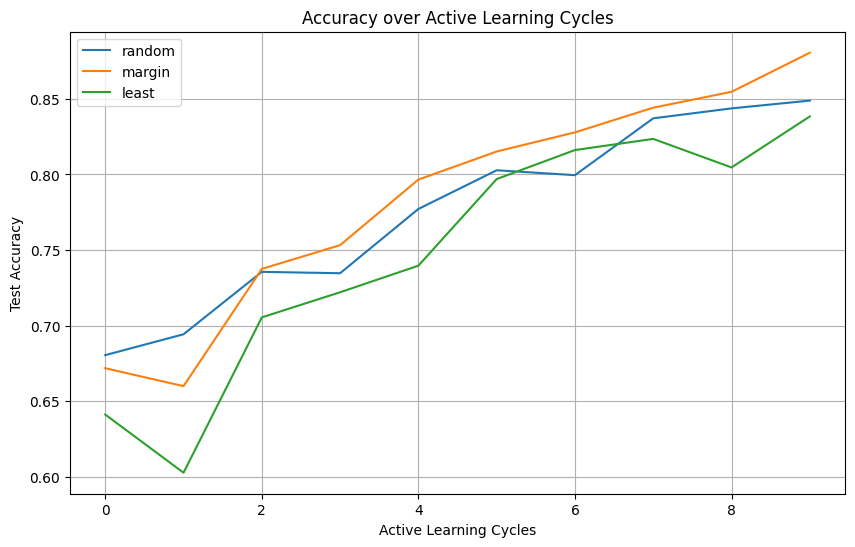

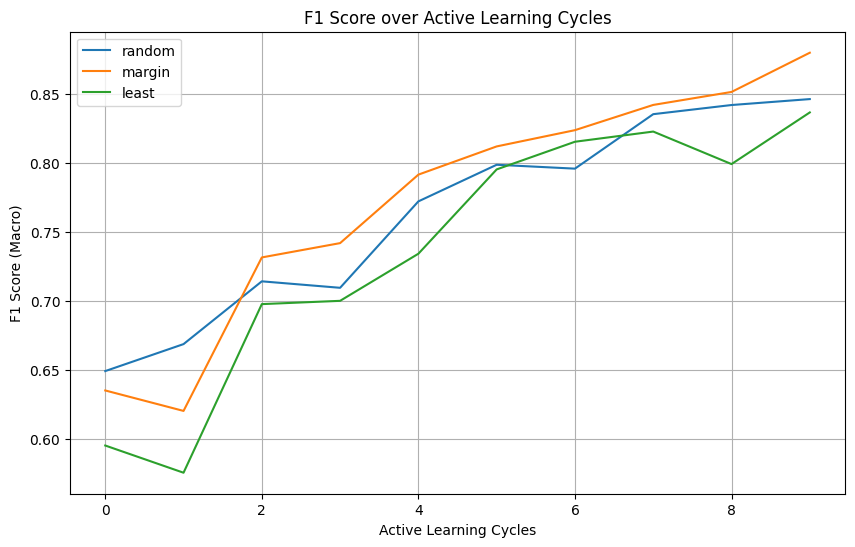

In [ ]:
# Dictionaries to store metrics across different strategies
results = {'random': [], 'margin': [], 'least': []}
f1_results = {'random': [], 'margin': [], 'least': []}

# Outer loop over multiple trials to get robust average performance
for trial in tqdm(range(trials), desc="Trials"):
    # Randomly shuffle dataset indices
    indices = np.random.permutation(len(full_dataset))
    # first 'initial_labeled' become labeled indices, rest are unlabeled
    labeled_idx, unlabeled_idx = indices[:initial_labeled], indices[initial_labeled:]
    
    # We'll compare 3 strategies for picking new points: random, margin, and least
    for strategy in ['random', 'margin', 'least']:
        # Current labeled/unlabeled sets for each strategy
        current_labeled = labeled_idx.copy()
        current_unlabeled = unlabeled_idx.copy()

        # Lists to track accuracy and F1 for each AL cycle
        accuracies = []
        f1_scores = []
        
        # Inner loop over Active Learning Cycles
        for cycle in tqdm(range(cycles), desc=f"{strategy.capitalize()} cycles", leave=False):
            # Train a fresh model on the current labeled set
            model = MNIST_CNN()
            optimizer = torch.optim.Adam(model.parameters())

            # Create a DataLoader for the labeled subset
            loader = DataLoader(Subset(full_dataset, current_labeled), batch_size=64, shuffle=True)
            
            # Simple training loop (single epoch)
            for images, labels in loader:
                optimizer.zero_grad()
                loss = torch.nn.functional.cross_entropy(model(images), labels)
                loss.backward()
                optimizer.step()
            
            # Evaluate the model on the test set
            test_loader = DataLoader(test_dataset, batch_size=512)
            correct = 0
            all_preds, all_labels = [], []
            with torch.no_grad():
                for images, labels in test_loader:
                    outputs = model(images)
                    preds = outputs.argmax(1)
                    correct += (preds == labels).sum().item()
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
            
            # Accuracy = number of correct predictions / total test samples
            accuracies.append(correct / len(test_dataset))
            # Macro F1 score across the 10 classes
            f1_scores.append(f1_score(all_labels, all_preds, average='macro'))
            
            # Choose new samples to label, based on different strategies
            if strategy == 'margin':
                # Margin-based sampling: pick examples with smallest difference between the top 2 predicted probabilities
                margin_scores = []
                unlabeled_loader = DataLoader(Subset(full_dataset, current_unlabeled), batch_size=512)
                with torch.no_grad():
                    for images, _ in unlabeled_loader:
                        probs = torch.softmax(model(images), dim=1)
                        top2 = torch.topk(probs, 2, dim=1).values
                        # difference between largest and second largest prob
                        margin_scores.append(top2[:, 0] - top2[:, 1])
                scores = torch.cat(margin_scores).cpu().numpy()
                # Select the 'budget' smallest margins
                selected = np.argpartition(scores, budget)[:budget]
            
            elif strategy == 'least':
                # Least-confidence sampling: pick examples with smallest
                # maximum predicted probability
                uncertainty_scores = []
                unlabeled_loader = DataLoader(Subset(full_dataset, current_unlabeled), batch_size=512)
                with torch.no_grad():
                    for images, _ in unlabeled_loader:
                        probs = torch.softmax(model(images), dim=1)
                        max_probs, _ = probs.max(dim=1)
                        # higher uncertainty = 1 - max_prob
                        uncertainty_scores.append(1 - max_probs)
                scores = torch.cat(uncertainty_scores).cpu().numpy()
                # select top 'budget' uncertain items
                selected = np.argpartition(scores, -budget)[-budget:]
            
            else:  # random
                 # Random sampling from the unlabeled pool
                selected = np.random.choice(len(current_unlabeled), budget, replace=False)
            
            # Move selected samples from unlabeled to labeled
            current_labeled = np.concatenate([current_labeled, current_unlabeled[selected]])
            current_unlabeled = np.delete(current_unlabeled, selected)
        
        # At the end of all cycles, store the entire lists of metrics
        results[strategy].append(accuracies)
        f1_results[strategy].append(f1_scores)

# Plot: Accuracy over Active Learning Cycles
plt.figure(figsize=(10,6))
for strategy in results:
    mean = np.mean(results[strategy], axis=0)
    plt.plot(range(cycles), mean, label=strategy)
plt.xlabel('Active Learning Cycles')
plt.ylabel('Test Accuracy')
plt.title('Accuracy over Active Learning Cycles')
plt.legend()
plt.grid(True)
plt.show()

# Plot: Macro F1 Score over Active Learning Cycles
plt.figure(figsize=(10,6))
for strategy in f1_results:
    mean = np.mean(f1_results[strategy], axis=0)
    plt.plot(range(cycles), mean, label=strategy)
plt.xlabel('Active Learning Cycles')
plt.ylabel('F1 Score (Macro)')
plt.title('F1 Score over Active Learning Cycles')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
print(results)

{'random': [[0.7557, 0.6037, 0.7314, 0.7215, 0.7893, 0.8152, 0.8016, 0.8327, 0.8276, 0.8311], [0.7109, 0.721, 0.7714, 0.7225, 0.7595, 0.8097, 0.7948, 0.8039, 0.8368, 0.8582], [0.6423, 0.6975, 0.737, 0.7629, 0.751, 0.7963, 0.8208, 0.8559, 0.844, 0.8581], [0.639, 0.7544, 0.6827, 0.7195, 0.7881, 0.7986, 0.7548, 0.8354, 0.8531, 0.8327], [0.654, 0.6944, 0.755, 0.7466, 0.7978, 0.7939, 0.8255, 0.8577, 0.857, 0.8641]], 'margin': [[0.6072, 0.6971, 0.7159, 0.7548, 0.7951, 0.8416, 0.8448, 0.8272, 0.8812, 0.866], [0.7142, 0.574, 0.7095, 0.8103, 0.8073, 0.7795, 0.8147, 0.8246, 0.8631, 0.8768], [0.6777, 0.7487, 0.6543, 0.8007, 0.8021, 0.8172, 0.8485, 0.8587, 0.8657, 0.8978], [0.6465, 0.6727, 0.7879, 0.7583, 0.7729, 0.8106, 0.7765, 0.8474, 0.8667, 0.8671], [0.713, 0.6069, 0.8197, 0.6418, 0.8054, 0.8269, 0.8546, 0.8629, 0.7966, 0.895]], 'least': [[0.6741, 0.6425, 0.7048, 0.7528, 0.7748, 0.8142, 0.8453, 0.8032, 0.7848, 0.8312], [0.7445, 0.7357, 0.7398, 0.7458, 0.7652, 0.7973, 0.8193, 0.7917, 0.8196, 0.